In [ ]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files={"train": "/content/drive/MyDrive/Uni/Sem 5/Deep Learning/Summarizer/cnn_dailymail/train.csv", "test": "/content/drive/MyDrive/Uni/Sem 5/Deep Learning/Summarizer/cnn_dailymail/test.csv"})


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
print(device)

cuda


In [ ]:
max_input_length = 1028
max_target_length = 128

dataset["train"] = dataset["train"].select(range(50000))
dataset["test"] = dataset["test"].select(range(10000))

def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Tokenize summaries
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

batch_size = 16

args = Seq2SeqTrainingArguments(
    "flan-t5-small-summarization",
    eval_strategy="steps", # Changed from evaluation_strategy
    eval_steps=2000,
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
!pip install evaluate
!pip install rouge_score

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=predictions, references=labels)
    return {k: v.mid.fmeasure for k, v in result.items()}

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-3627515418.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
val_dataset = load_dataset("csv", data_files={"validation": "/content/drive/MyDrive/Uni/Sem 5/Deep Learning/Summarizer/cnn_dailymail/validation.csv"})["validation"]

val_dataset = val_dataset.select(range(200))

In [ ]:
val_tokenized = val_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
import evaluate

rouge = evaluate.load("rouge")

def evaluate_model(dataset):
    preds = []
    refs = []
    for example in dataset:
        inputs = tokenizer("summarize: " + example["article"], return_tensors="pt", truncation=True).to(model.device)
        summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4)
        pred = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        preds.append(pred)
        refs.append(example["highlights"])

    results = rouge.compute(predictions=preds, references=refs)
    return results

results = evaluate_model(val_dataset)
print(results)


{'rouge1': np.float64(0.3653829617796094), 'rouge2': np.float64(0.16595869601869617), 'rougeL': np.float64(0.25199120308548206), 'rougeLsum': np.float64(0.3189920866402329)}


In [ ]:
text = val_dataset[0]["article"]
inputs = tokenizer("summarize: " + text, return_tensors="pt").to(model.device)
summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4)
print("Generated:", tokenizer.decode(summary_ids[0], skip_special_tokens=True))
print("Reference:", val_dataset[0]["highlights"])


Generated: Sally Forrest, an actress-dancer who graced the silver screen throughout the '40s and '50s in MGM musicals and films such as the 1956 noir While the City Sleeps, died on March 15 at her home in Beverly Hills, California. Forrest, whose birth name was Katherine Feeney, was 86 and had long battled cancer. Her publicist, Judith Goffin, announced the news Thursday. Forrest appeared as herself in an episode of The Ed Sullivan Show and three episodes of The Dinah Shore Chevy Show.
Reference: Sally Forrest, an actress-dancer who graced the silver screen throughout the '40s and '50s in MGM musicals and films died on March 15 .
Forrest, whose birth name was Katherine Feeney, had long battled cancer .
A San Diego native, Forrest became a protege of Hollywood trailblazer Ida Lupino, who cast her in starring roles in films .


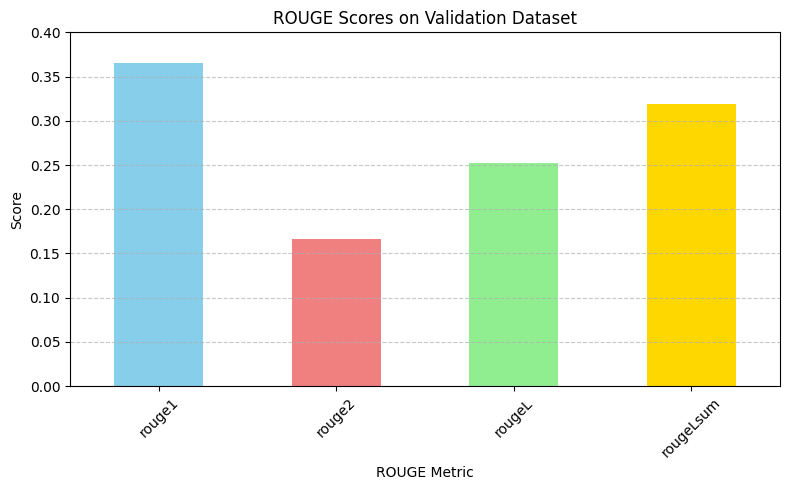

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert results dictionary to a pandas Series for easy plotting
results_series = pd.Series(results)

plt.figure(figsize=(8, 5))
results_series.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('ROUGE Scores on Validation Dataset')
plt.xlabel('ROUGE Metric')
plt.ylabel('Score')
plt.ylim(0, 0.4) # ROUGE scores typically range from 0 to 1
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
trainer.save_model("/content/drive/MyDrive/Uni/Sem 5/Deep Learning/Summarizer/50k/")